<a href="https://colab.research.google.com/github/alen-george/Chatbot/blob/Baby-monitoring/Baby_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import numpy as np
import tensorflow as tf


In [18]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.compat.v1.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  
  return result

In [21]:
def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.compat.v2.io.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

In [23]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [24]:




file_name = "/content/drive/MyDrive/Colab Notebooks/SavedModel/sleeping1.jpg"
model_file = "/content/drive/MyDrive/Colab Notebooks/SavedModel/SavedModel.pb"
label_file = "/content/drive/MyDrive/retrained_labels.txt"
input_height = 299
input_width = 299
input_mean = 0
input_std = 255
input_layer = "Mul"
output_layer = "final_result"

graph = load_graph(model_file)
t = read_tensor_from_image_file(
      file_name,
      input_height=input_height,
      input_width=input_width,
      input_mean=input_mean,
      input_std=input_std)

In [25]:
  input_name = "import/" + input_layer
  output_name = "import/" + output_layer
  input_operation = graph.get_operation_by_name(input_name)
  output_operation = graph.get_operation_by_name(output_name)

In [27]:
with tf.Session(graph=graph) as sess:

  results = sess.run(output_operation.outputs[0], {
        input_operation.outputs[0]: t
    })
  results = np.squeeze(results)

  top_k = results.argsort()[-5:][::-1]
  labels = load_labels(label_file)
  for i in top_k:
    print('Probability of',labels[i], results[i])
  max_index = np.where(results == np.amax(results))
  print('So the baby is',labels[int(max_index[0])])

Probability of sleeping 0.6127658
Probability of awake 0.38186997
Probability of crying 0.0053642103
So the baby is sleeping


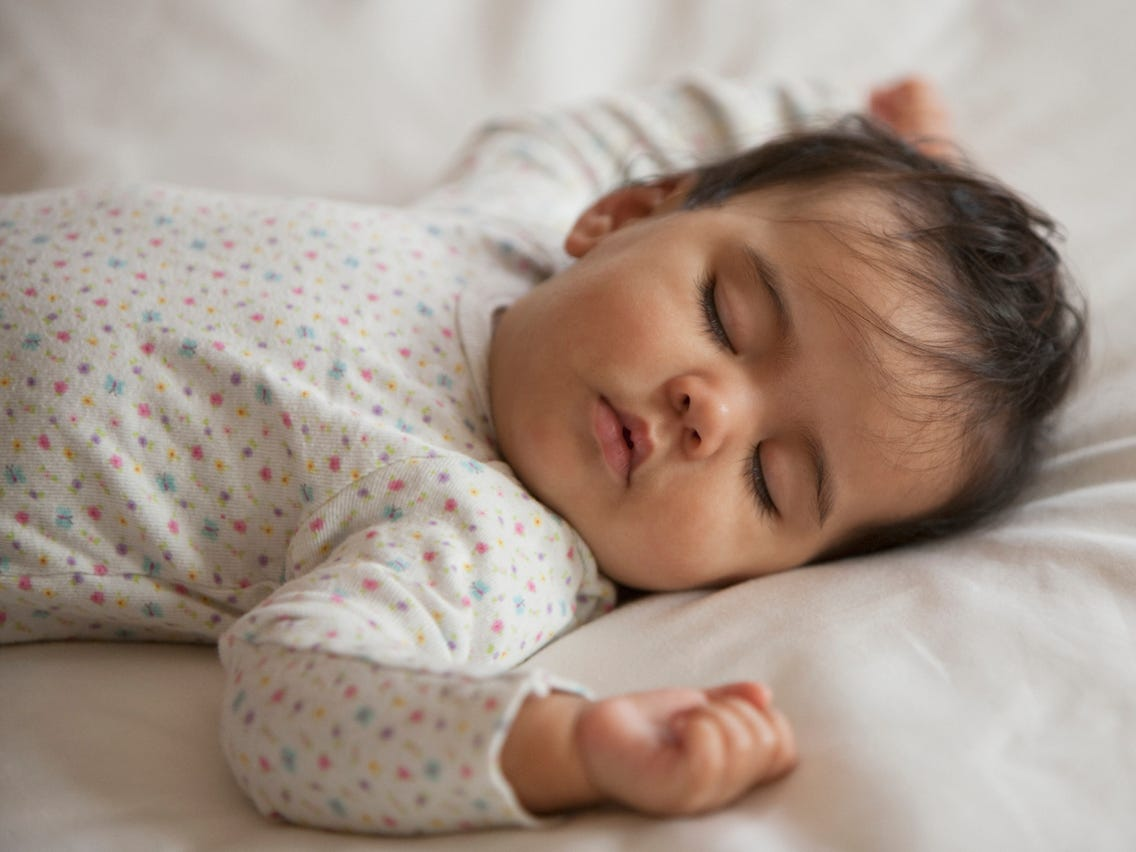

In [32]:
from IPython.display import Image


Image('/content/drive/MyDrive/Colab Notebooks/SavedModel/sleeping1.jpg', width=100, height=100)

